In [1]:
from goetia.hashing import UKHShifter
from goetia.minimizers import UKHSSignature, UKHSCountSignature
from goetia.processors import UKHSCountSignatureProcessor
import screed
import numpy as np
from scipy.spatial import distance
from glob import glob
import os
import pandas as pd
import seaborn as sns
from ficus import FigureManager
import re
from collections import OrderedDict
import yaml
from yaml import CLoader as Loader, CDumper as Dumper
import json
from sklearn.manifold import TSNE
from skbio.stats.distance import mantel
from snakemake.utils import listfiles
from scipy.stats import kendalltau as KennyT

/home/camille/miniconda/envs/libgoetia/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def load_fastani_matrix(filename):
    df = pd.read_csv(filename, delimiter='\t',
                     names=['A', 'B', 'ani', 'matches', 'n_fragments'])
    df['A'] = [os.path.basename(n) for n in df.A]
    df['B'] = [os.path.basename(n) for n in df.B]
    
    sim_df    = df.set_index(['A', 'B'])['ani'].unstack()
    dissim_df = (100 - sim_df) / 100
    dissim_df.values[[np.arange(dissim_df.shape[0])]*2] = 0
    make_sym(dissim_df)
    
    return df, dissim_df

In [3]:
def load_sourmash_matrix(np_mat_filename, labels_filename):
    labels = [os.path.basename(line.split()[0]) 
              for line in open(labels_filename).readlines()]
    mat = np.load(np_mat_filename)
    df  = pd.DataFrame(mat, columns=labels, index=labels)
    
    dissim_df = 1 - df
    dissim_df.values[[np.arange(dissim_df.shape[0])]*2] = 0

    return df, dissim_df

In [4]:
def load_ukhs_sigs_matrix(sig_filenames, metric='cosine'):
    sigs = {}
    for sigfile in sig_filenames:
        with open(sigfile) as fp:
            data = json.load(fp)[0]
            sigs[data['name']] = data['signature']
    df = pd.DataFrame(sigs).T
    sim_df = pd.DataFrame(distance.squareform(distance.pdist(df.values, metric)),
                          columns = df.index,
                          index = df.index)
    sim_df = sim_df.sort_index(axis=0).sort_index(axis=1)
    return df, sim_df

In [9]:
def get_streaming_distances(filename, metric='cosine'):
    df = pd.read_csv(filename, index_col=0, sep=',', engine='c', header=None, na_filter=False, dtype=np.uint64, low_memory=False)
    dfunc = getattr(distance, metric)
    
    distances = np.zeros(len(df) - 1, dtype=np.float64)
    for i in range(len(df) - 1):
        distances[i] = dfunc(df.values[i, :], df.values[i+1, :])
    ddf = pd.DataFrame({'read_n':     df.index[1:],
                        'd_distance': distances})
    ddf['t'] = ddf['read_n'] / ddf['read_n'].max()
    
    return df, ddf

## Ecoli Benchmarking Data

In [ ]:
fastani_df, fastani_dissim_df = load_fastani_matrix('ecoli_many_sigs/all_by_all_ani.txt')

In [ ]:
sourmash_df, sourmash_dissim_df = load_sourmash_matrix('ecoli_many_sigs/sourmash_sim.npb',
                                                       'ecoli_many_sigs/sourmash_sim.txt.labels.txt')
sourmash_dissim_df.drop('NC_027387.1.fa', inplace=True)
sourmash_dissim_df.drop('NC_027387.1.fa', inplace=True, axis=1)

In [ ]:
ukhs_df, ukhs_dissim_df = load_ukhs_sigs_matrix(glob('ecoli_many_sigs/*.uksig.json'))
ukhs_dissim_df.drop('NC_027387.1.fa', inplace=True)
ukhs_dissim_df.drop('NC_027387.1.fa', inplace=True, axis=1)

In [ ]:
ukhs_dissim_df.head(2)

In [ ]:
fastani_dissim_df.head(2)

In [ ]:
sourmash_dissim_df.head(2)

#### Correlation With FastANI

In [ ]:
mantel(fastani_dissim_df, sourmash_dissim_df)

In [ ]:
mantel(fastani_dissim_df, ukhs_dissim_df)

In [ ]:
mantel(ukhs_dissim_df, sourmash_dissim_df)

In [ ]:
ukhs_df, ukhs_dissim_df = load_ukhs_sigs_matrix(glob('ecoli_many_sigs/*.uksig.json'))
ukhs_dissim_df.drop('NC_027387.1.fa', inplace=True)
ukhs_dissim_df.drop('NC_027387.1.fa', inplace=True, axis=1)

In [ ]:
for W in [31, 51]:
    for K in [7, 8, 9]:
        files = glob('/work/scihack/2019-03-08-scihack/results/ecoli/{0}/{1}/*.sig'.format(W, K))
        edf, eddf = load_ukhs_sigs_matrix(files)
        eddf.drop('NC_027387.1.fa', inplace=True)
        eddf.drop('NC_027387.1.fa', inplace=True, axis=1)
        print(W, K, mantel(fastani_dissim_df, eddf))
        print(W, K, KennyT(eddf.values.flatten(), fastani_dissim_df.values.flatten()))
        print()

In [ ]:
#with FigureManager(figsize=(15,15), show=True) as (fig, ax):
jp = sns.jointplot(x='ukhs', y='ANI', height=12,
                       data=pd.DataFrame({'ukhs': ukhs_dissim_df.values.flatten(), 
                                          'ANI': fastani_dissim_df.values.flatten()}) )

In [ ]:
jp.savefig('ukhs_ani_joint.png')

In [ ]:
sns.clustermap(fastani_dissim_df, square=True, xticklabels=False, figsize=(15,15))

In [ ]:
ukhs_cm = sns.clustermap(ukhs_dissim_df, square=True, xticklabels=False, figsize=(15,15))
ukhs_cm.savefig('ecoli.ukhssig.clustered.png')

In [ ]:
sns.clustermap(sourmash_dissim_df, square=True, xticklabels=False)

### UKHS Signature Viz

In [ ]:
with FigureManager(figsize=(18, 8), show=True) as (fig, ax):
    sns.heatmap(ecoli_sig_data.clip(upper=1000), xticklabels=False, ax=ax)

In [ ]:
sns.clustermap(ecoli_sig_data.clip(upper=1000), cbar=False,
               xticklabels=False, figsize=(20,12))

## Streaming Signature Experimentation

In [10]:
hu_files = sorted(list(listfiles('/work/scihack/2019-03-08-scihack/results/hu/31/9/{hu_id}.sigs.csv')), key=lambda item: item[1].hu_id)
hu_data = {}
for fn, wildcards in hu_files:
    df, ddf = get_streaming_distances(fn)
    hu_data[wildcards.hu_id] = {'sigs': df, 'distances': ddf}

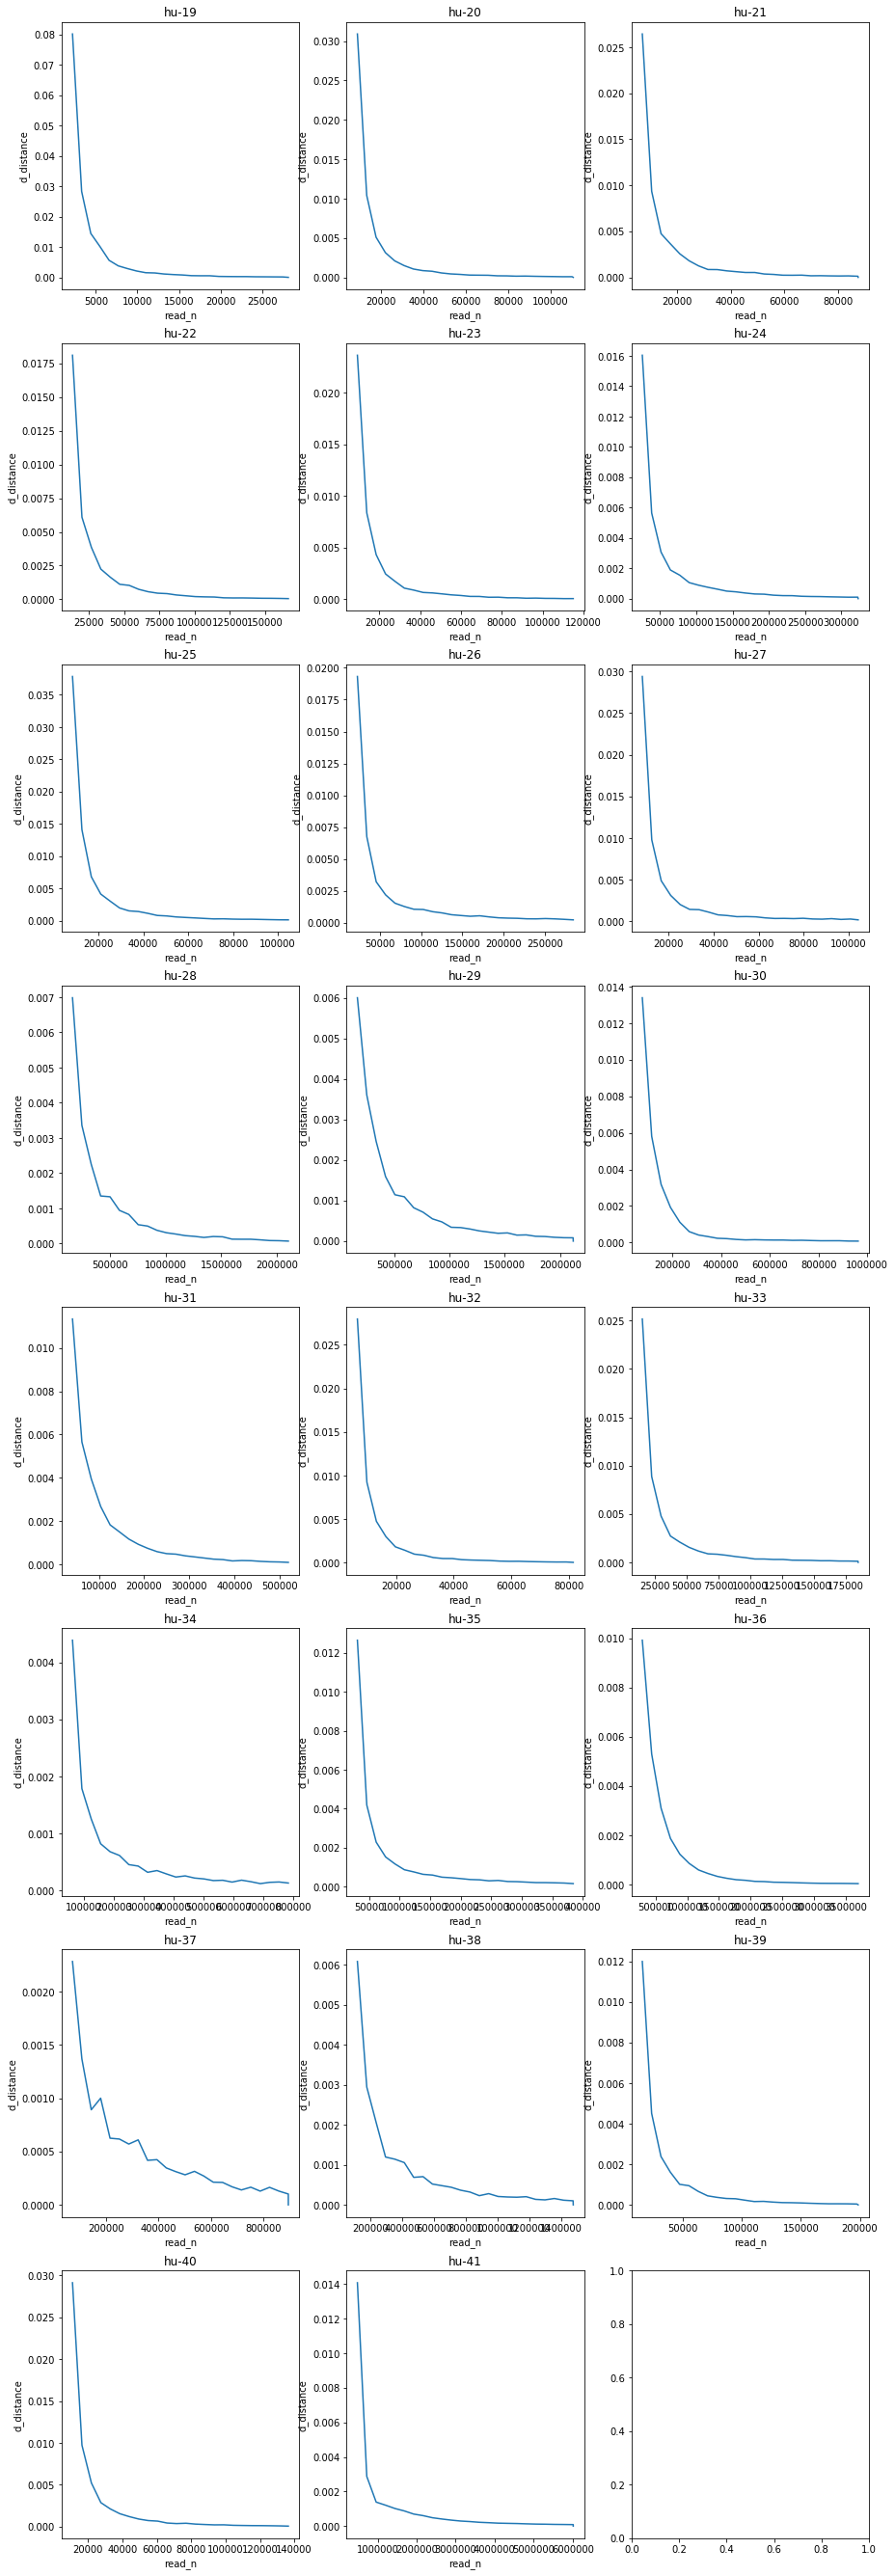

In [12]:
ncols, nrows = 3, 8
with FigureManager(figsize=(15,48), nrows=nrows, ncols=ncols, show=True) as (fig, ax):
    for i, (hu_id, data) in enumerate(hu_data.items()):
        row = i // ncols
        col = i % ncols

        try:
            sns.lineplot(x='read_n', y='d_distance', ax=ax[row][col], data=data['distances'])
            ax[row][col].set_title(hu_id)
        except:
            pass

In [11]:
df, ddf = get_streaming_distances('/work/scihack/2019-03-08-scihack/results/mmetsp/31/9/SRR1300445.sigs.csv')

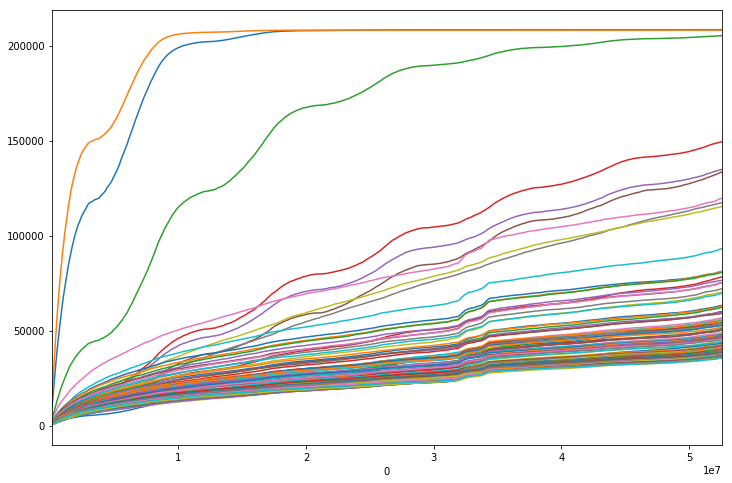

In [12]:
with FigureManager(figsize=(12,8), show=True) as (fig, ax):
    df.sort_values(df.index[-1], axis=1, ascending=False).T.iloc[:100].T.plot(ax=ax, legend=False)

In [ ]:
log_df = np.log2(mmetsp_streaming_df)

In [ ]:
log_df.values[np.isneginf(log_df.values)] = 0

In [ ]:
with FigureManager(figsize=(20, 10), show=True, filename='Ast_gla.streamed.sigs.sorted.png') as (fig, ax):
    sns.heatmap(log_df.sort_values(13221196, axis=1), xticklabels=False, ax=ax)

In [ ]:
clst = sns.clustermap(log_df, col_cluster=True, row_cluster=False, xticklabels=False, figsize=(15,15))

In [ ]:
clst.savefig('Ast_gla.streamed.sigs.clustered.png')

## Hu Metagenome

In [ ]:
hu_df, hu_dissim_df = load_ukhs_sigs_matrix(glob('/work/scihack/2019-03-08-scihack/results/hu/31/9/*.sig'))

In [ ]:
hu_cm = sns.clustermap(hu_dissim_df, square=True, xticklabels=False, figsize=(15,15))
hu_cm.savefig('hu.ukhssig.clustered.png')

## MMETSP Experimentation

In [ ]:
assemblies = glob('/store/public/sequencing-runs/MMETSP/data/assemblies/*.fasta')

In [ ]:
mmetsp_sigs, mmetsp_sig_df, mmetsp_dist_df = build_sigs(assemblies[:20])

In [ ]:
with FigureManager(figsize=(8, 20), show=True) as (fig, ax):
    sns.heatmap(mmetsp_sig_df.T.clip(upper=10000), yticklabels=False, ax=ax)

In [ ]:
sns.clustermap(mmetsp_sig_df.T.clip(upper=10000), yticklabels=False, figsize=(8,10), row_cluster=True)

In [ ]:
n_sigs = len(sigs)
with FigureManager(figsize=(12, 2 * n_sigs), nrows=n_sigs, show=True) as (fig, ax):
    for n, (gen, name, sig) in enumerate(sigs):
        sns.heatmap(sig.T, xticklabels=False, yticklabels=False, cbar=False, ax=ax[n])